In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Load some data from previous MBHB runs with lisabeta
We read signals only in 's' and noise+signal 'ns' and compute noise only 'n'.

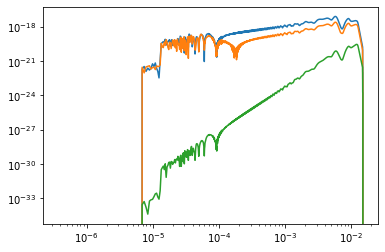

In [2]:
rundir='/data/jgbaker/MBHB/GapDev/runs/plat-tests/'    #on globe
##minf=3e-5
#label_s='PHM-j-LDC1-P3-b_0_s16'
#label_ns='PHM-j-LDC1N-P3-b_0_s16'
##minf-1e-9
label_s='PHM-j-LDC1_s-P3-b_0_s16'
label_ns='PHM-j-LDC1_ns-P3-b_0_s16'
data_file=rundir+label_s+'/'+label_s+'_data.txt'
data=np.loadtxt(data_file,skiprows=3)
data_file=rundir+label_ns+'/'+label_ns+'_data.txt'
datans=np.loadtxt(data_file,skiprows=3)
datan=datans.copy()
datan[:,1:]-=data[:,1:]
plt.loglog(data[:,0],np.absolute(data[:,1]+1j*data[:,2]))
plt.loglog(data[:,0],np.absolute(data[:,3]+1j*data[:,4]))
plt.loglog(data[:,0],np.absolute(data[:,5]+1j*data[:,6]))
                                                  

### Load a lisabeta noise model
It is also now possible to produce this kind of model from tabulated PSD data. Not yet here.

453.07375915987814 205275.83123926327
135.10937620317813 18254.543538011916
2.5574240446338172 6.540417744071192
472.79690692200944


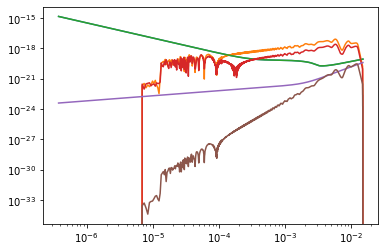

In [3]:
#Load some noise models from lisabeta
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
fs=data[:,0]
df=data[1,0]-data[0,0]
#LISAnoise={'InstrumentalNoise': 'SciRDv1', 'WDbackground': False, 'WDduration': 0.0, 'lowf_add_pm_noise_f0': 0.0, 'lowf_add_pm_noise_alpha': 2.0}
LISAnoise={'InstrumentalNoise': 'Proposal', 'WDbackground': True, 'WDduration': 3.0, 'lowf_add_pm_noise_f0': 0.0, 'lowf_add_pm_noise_alpha': 2.0}
resc=False
S_A=pyLISAnoise.LISANoisePSDFunction(LISAnoise,1,TDIrescaled=resc).apply(fs)
S_E=pyLISAnoise.LISANoisePSDFunction(LISAnoise,2,TDIrescaled=resc).apply(fs)
S_T=pyLISAnoise.LISANoisePSDFunction(LISAnoise,3,TDIrescaled=resc).apply(fs)
#set a floor?
S_A=S_A+fs*1e-44*0
S_E=S_E+fs*1e-44*0
S_T=S_T+fs*1e-44*0
plt.loglog(fs,np.sqrt(S_A/fs),fs,np.absolute(data[:,1]+1j*data[:,2]))
plt.loglog(fs,np.sqrt(S_E/fs),fs,np.absolute(data[:,3]+1j*data[:,4]))
plt.loglog(fs,np.sqrt(S_T/fs),fs,np.absolute(data[:,5]+1j*data[:,6]))
SNR2A=sum(np.abs(data[:,1]+1j*data[:,2])**2/S_A)*4*df
print(np.sqrt(SNR2A),SNR2A)
SNR2E=sum(np.abs(data[:,3]+1j*data[:,4])**2/S_E)*4*df
print(np.sqrt(SNR2E),SNR2E)
SNR2T=sum(np.abs(data[:,5]+1j*data[:,6])**2/S_T)*4*df
print(np.sqrt(SNR2T),SNR2T)
print(np.sqrt(SNR2A+SNR2E+SNR2T))

### Define function for comparing spectra, and compare data with noise models

n= 29999
nbins= 173
plot_compare_spectra: Assuming list of np data.
chan 0 data set stds: [9.54237926e-18 8.26521060e-18]
i max: 6978 8.802569448860995
i max: 26025 4.427199372970116
chan 1 data set stds: [9.32232913e-18 9.17786778e-18]
i max: 8069 4.790381475583606
i max: 3641 4.390379108100526
chan 2 data set stds: [2.66143312e-18 2.66138064e-18]
i max: 19560 4.08700036589936
i max: 19560 4.0926378317549545


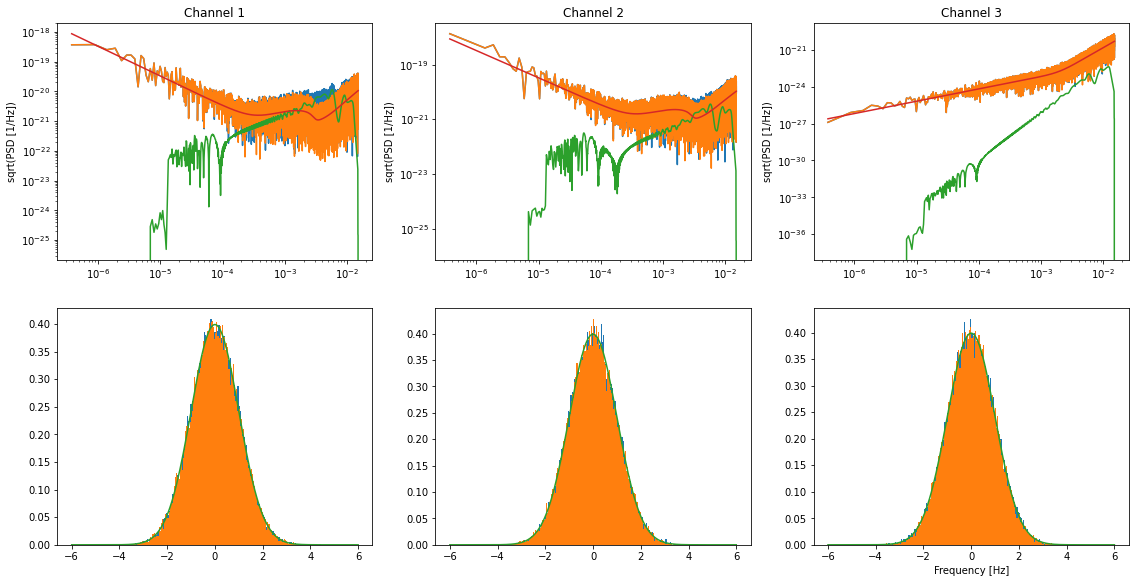

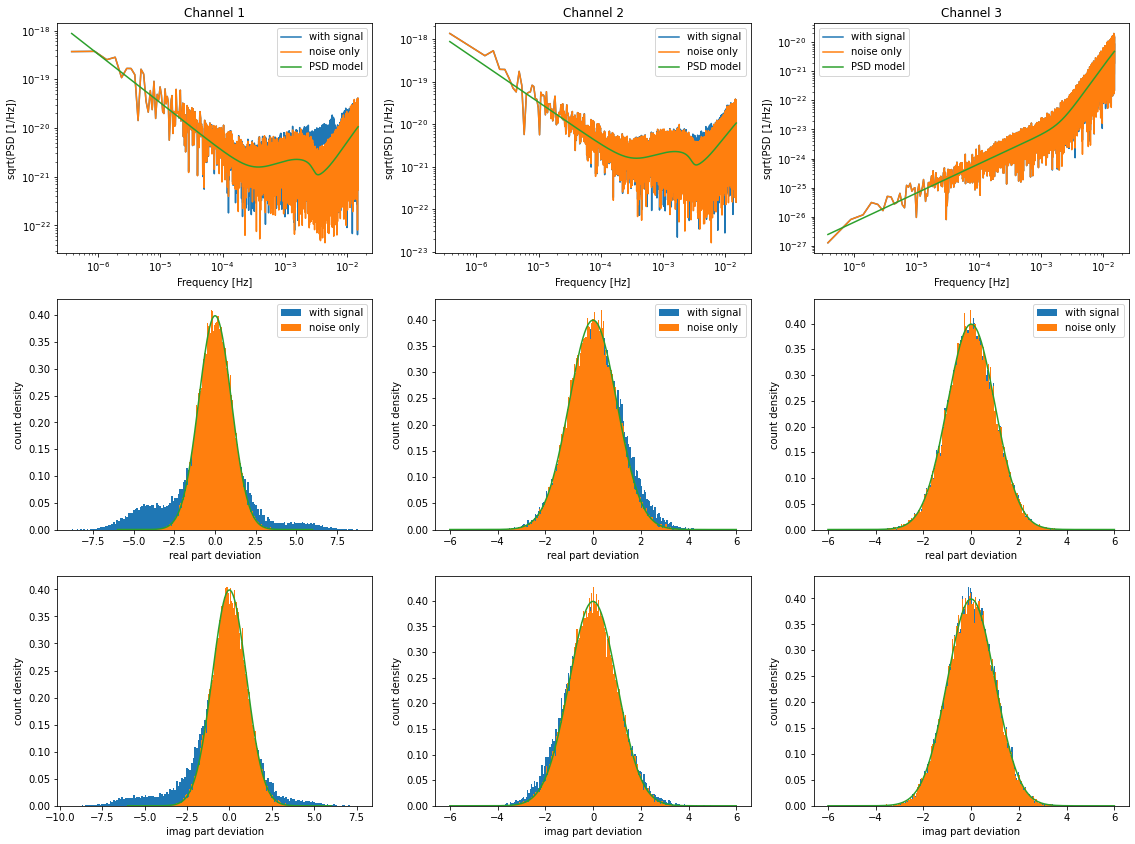

In [4]:

from scipy.stats import norm
#label='PHM-j-LDC1N-P3-b_0_s16'
#data_file=rundir+label+'/'+label+'_data.txt'
#datans=np.loadtxt(data_file,skiprows=3)
#datan=datans.copy()
#datan[:,1:]-=data[:,1:]
fig, axs = plt.subplots(2,3,figsize=[19.2,9.6])
nn=len(datan)
print('n=',nn)
nbins=int(np.sqrt(nn))
print('nbins=',nbins)
x=np.linspace(-6,6,nbins)
for ich in range(3): 
    ax=axs[0,ich]
    ax.set_title(r"Channel "+str(ich+1))
    plt.xlabel(r"Frequency [Hz]")
    ax.set_ylabel("sqrt(PSD [1/Hz])") 
    scalefac=np.sqrt(4*df)
    ax.loglog(fs, np.abs(datans[:,ich*2+1]+1j*datans[:,ich*2+2])*scalefac , label="Sig+Noise")
    ax.loglog(fs, np.abs(datan[:,ich*2+1]+1j*datan[:,ich*2+2])*scalefac , label="Noise")
    ax.loglog(fs, np.abs(data[:,ich*2+1]+1j*data[:,ich*2+2])*scalefac , label="Signal")
    ax.loglog(fs, np.sqrt([S_A,S_E,S_T][ich]), label="Ch "+str(ich)+" PSD model")
    ax=axs[1,ich]
    nn=len(datan)
    #print('n=',nn)
    nbins=int(np.sqrt(nn))
    ax.hist(datan[1:,ich*2+1]*scalefac/np.sqrt([S_A,S_E,S_T][ich][1:]),bins=nbins,density=True)
    ax.hist(datan[1:,ich*2+2]*scalefac/np.sqrt([S_A,S_E,S_T][ich][1:]),bins=nbins,density=True)
    ax.plot(x,norm.pdf(x))
    
def plot_compare_spectra(datasets,LISAnoise=None,nchan=3,labels=None,fs=None,PSDset=None):
    if fs is None:
        print('plot_compare_spectra: Assuming list of np data.')
        fs=datasets[0][:,0]
        pdata=[]
        for dataset in datasets:
            pdatai=[]
            for ich in range(nchan):
                pdatai+=[dataset[:,ich*2+1]+1j*dataset[:,ich*2+2]]
            pdata+=[pdatai]
    else:
        print('plot_compare_spectra: Assuming list of list-packed data on common freq grid.')
        pdata=datasets
    if labels is None:
        labels=[]
        for i in range(len(pdata)):labels.append('Set '+str(i+1))
    resc=False
    noises=[]
    for ich in range(nchan):
        if LISAnoise is not None:
            noises += [pyLISAnoise.LISANoisePSDFunction(LISAnoise,ich+1,TDIrescaled=resc).apply(fs)]
        elif PSDset is not None:
            noises += [PSDset[ich].calculate(fs)]
        else:
            raise ValueError['Must provide either LISAnoise or PSDset']
    fig, axs = plt.subplots(3,3,figsize=[19.2,14.4])
    nbins=int(np.sqrt(len(fs)))
    x=np.linspace(-6,6,nbins)
    for ich in range(nchan): 
        ax=axs[0,ich]
        ax.set_title(r"Channel "+str(ich+1))
        ax.set_xlabel(r"Frequency [Hz]")
        ax.set_ylabel("sqrt(PSD [1/Hz])")
        scalefac=np.sqrt(4*(fs[1]-fs[0]))
        iset=0
        for pdataset in pdata:
            iset=iset+1
            ax.loglog(fs, np.abs(pdataset[ich])*scalefac , label=labels[iset-1])
        ax.loglog(fs, np.sqrt(noises[ich]), label="PSD model")
        ax.legend()
        nn=len(fs)
        nbins=int(np.sqrt(nn))
        stds=np.zeros(len(pdata))
        for i in range(len(pdata)):
            stds[i]=np.std(pdata[i][ich][1:-1].real)
            stds[i]+=np.std(pdata[i][ich][1:-1].imag)
        print('chan '+str(ich)+' data set stds:',stds)
        largesets=[pdata[i] for i in range(len(pdata)) if stds[i]/stds.mean()>0.001]                                             
        ax=axs[1,ich]
        for dataset in largesets:
            xx=dataset[ich][1:-1].real*scalefac/np.sqrt(noises[ich][1:-1])
            imax=np.argmax(xx)
            print('i max:',imax,xx[imax])
            ax.hist(dataset[ich][1:-1].real*scalefac/np.sqrt(noises[ich][1:-1]),bins=nbins,density=True)
        ax.set_xlabel("real part deviation")
        ax.set_ylabel("count density")
        ax.legend(labels=[labels[i] for i in range(len(pdata)) if stds[i]/stds.mean()>0.001])
        ax.plot(x,norm.pdf(x))
        ax=axs[2,ich]
        for dataset in largesets:ax.hist(dataset[ich][1:-1].imag*scalefac/np.sqrt(noises[ich][1:-1]),bins=nbins,density=True)
        ax.set_xlabel("imag part deviation")
        ax.set_ylabel("count density")
        ax.plot(x,norm.pdf(x))



plot_compare_spectra([datans,datan],LISAnoise,labels=["with signal","noise only"])

### Specify some gaps and generate gapped data
Based on the signal+noise data

In [5]:
#Set up gaps
nf=len(datans)+int(fs[0]/df-.5)
print('nn,nf,nf-nn',nn,nf,nf-nn)
print('f0,df,f0/df',fs[0],df,fs[0]/df)
bufdata=1j*np.zeros(nf)
fftfs=df*np.arange(nf)
nt=2*(nf-1)
dt = 1/(fs[-1]*2)
#tscalefac=np.sqrt(.5)/nt/df
#tscalefac*=tscalefac
tscalefac=1/dt
#Construct time-domain data
#note y is the inverse-fft which is time-domain channel*dt in our usage
y=[]
nchan=3
for i in range(nchan):
    bufdata[nf-nn:]=datans[:,1+i*2]+1j*datans[:,2+i*2]
    y += [np.fft.irfft(bufdata)*tscalefac]
    print('y['+str(i)+'],shape=',y[i].shape)
    
#construct gaps
mask = np.ones(nt)
ts=np.arange(nt)*dt
n_gaps = 3
gapstarts = (nn * np.random.random(n_gaps)).astype(int)
gaplength = 20
print('gap size is',dt*gaplength,'s')
gapends = (gapstarts+gaplength).astype(int)
for k in range(n_gaps): mask[gapstarts[k]:gapends[k]]= 0
print('mask.shape=',mask.shape)
y_masked=[]
for i in range(nchan):
    y_masked += [ mask * y[i] ]
for i in range(n_gaps):
    print('gap',i,':',gapstarts[i],'< i <',gapends[i],ts[gapstarts[i]],'< t <',ts[gapends[i]])

nn,nf,nf-nn 29999 29999 0
f0,df,f0/df 3.75e-07 5e-07 0.75
y[0],shape= (59996,)
y[1],shape= (59996,)
y[2],shape= (59996,)
gap size is 666.6944456019002 s
mask.shape= (59996,)
gap 0 : 28297 < i < 28317 943272.6363598484 < t < 943939.3308054503
gap 1 : 26922 < i < 26942 897437.3932247178 < t < 898104.0876703197
gap 2 : 21358 < i < 21378 711962.9984582692 < t < 712629.6929038711


### Define some functions for gap processing
- reconstruct_time_domain: 
  from FD data
- construct_specialized_data:
  TD to FD conversion
- Plot demonstrates effectiveness in preproducing the data by stransforming to TD and back to FD with these functions

3.75e-07 < f < 0.014999374999999999  nd= 29999  nf= 29999 df= 5e-07
nn,nf,nf-nn 29999 29999 0
nt,dt: 59996 33.33472228009501
recon scale: 0.029998749999999998 59996 5e-07
con scale: 0.02999875 59996 5e-07
3.75e-07 < f < 0.014999375  nd= 29999  nf= 29999 df= 5e-07
nn,nf,nf-nn 29999 29999 0
nt,dt: 59996 33.334722280095
recon scale: 0.029998749999999998 59996 5e-07
plot_compare_spectra: Assuming list of np data.
chan 0 data set stds: [8.26521060e-18 8.26521060e-18 4.09062952e-33]
i max: 26025 4.427199372970116
i max: 26025 4.427199372970115
chan 1 data set stds: [9.17786778e-18 9.17786778e-18 4.53683292e-33]
i max: 3641 4.390379108100526
i max: 3641 4.390379108100524
chan 2 data set stds: [2.66138064e-18 2.66138064e-18 1.28677466e-33]
i max: 19560 4.0926378317549545
i max: 19560 4.0926378317549545
start vals:
 datans: [ 2.48527158e-16 -8.34445430e-17  1.29147604e-16 -9.47127668e-16
  7.91684834e-25  4.17108686e-25] 
     yy: [2.48527158e-16 0.00000000e+00 1.29147604e-16 0.00000000e+00
 7.

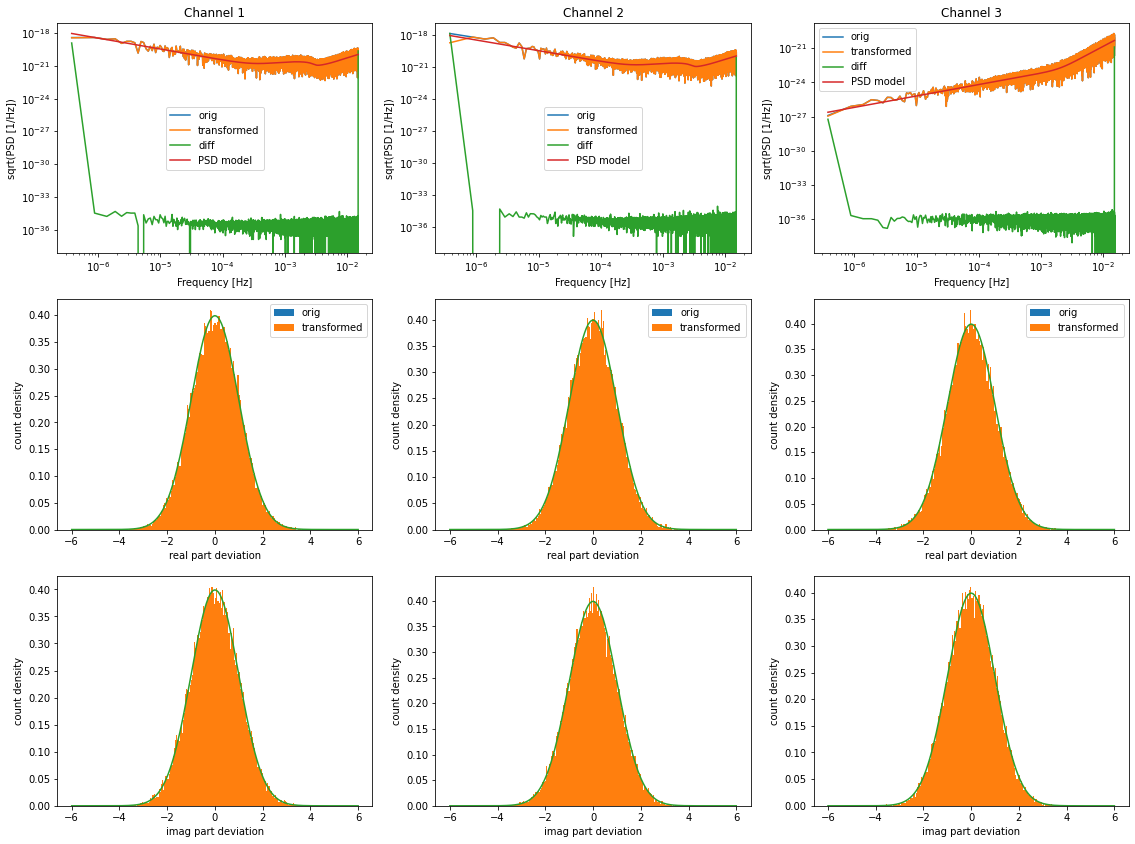

In [6]:
def reconstruct_time_domain(data,nchan):
    #Assume that fs are cell-centered labels of data elements
    #and evenly spaced in freq, over some band
    #assume data cols are freq, ch1.real, ch1.imag, ch2.real,... 
    fs=data[:,0]
    nd=len(data)
    df=(fs[-1]-fs[0])/(nd-1)
    nf=nd+int(fs[0]/df-.5)
    print(fs[0],'< f <',fs[-1],' nd=',nd,' nf=',nf,'df=',df)
    print('nn,nf,nf-nn',nn,nf,nf-nn)
    #print('f0,df,f0/df',fs[0],df,fs[0]/df)
    fftfs=df*np.arange(nf)
    nt=2*(nf-1)
    dt = 1/(fs[-1]*2)
    print('nt,dt:',nt,dt)
    #tscalefac=np.sqrt(.5)/nt/df
    #tscalefac=1/dt
    print('recon scale:',tscalefac,nt,df)
    #Construct time-domain data
    #note y is the inverse-fft which is time-domain channel*dt in our usage
    y=[]
    for i in range(nchan):
        bufdata=1j*np.zeros(nf)
        bufdata[nf-nn:]=data[:,1+i*2]+1j*data[:,2+i*2]
        ##set ends to vanish
        #bufdata[0]=0;bufdata[-1]=0
        y += [np.fft.irfft(bufdata)*tscalefac]
        #print('y['+str(i)+'],shape=',y[i].shape)
        
    return y

def construct_specialized_data(yt,nchan,df,f0):
    #Assume that fs are cell-centered labels of data elements
    #and evenly spaced in freq, over some band
    #assume data cols are freq, ch1.real, ch1.imag, ch2.real,... 
    nt=len(yt[0])
    nf=nt//2+1
    ioff=int(f0/df-.5)
    nd=nf-ioff
    fs=np.arange(nd)*df+f0
    #tscalefac=np.sqrt(.5)/nt/df
    #tscalefac=1/dt='fs'
    tscalefac=2*fs[-1]
    print('con scale:',tscalefac,nt,df)
    yf=np.zeros((nd,1+nchan*2))
    yf[:,0]=fs
    for i in range(nchan):
        #print('len(yt)',len(yt[i]))
        yfft=np.fft.rfft(yt[i]/tscalefac)
        #print('nd,ioff,len(yfft[ioff:])',nd,ioff,len(yfft[ioff:]))
        yf[:,1+2*i] += yfft[ioff:].real
        yf[:,2+2*i] += yfft[ioff:].imag
        
    return yf

datax=datan
yy = reconstruct_time_domain(datax,3)

yyf = construct_specialized_data(yy,3,df,fs[0])
yyt = reconstruct_time_domain(yyf,3)

dyy=yyf.copy()
dyy[:,1:]-=datax[:,1:]
plot_compare_spectra([datax,yyf,dyy],LISAnoise,labels=['orig','transformed','diff'])

print("start vals:\n datans:",datans[0][1:],"\n     yy:",yyf[0][1:])
print("near start vals:\n datans:",datans[1][1:],"\n     yy:",yyf[1][1:])
print("end vals:\n datans:",datans[-1][1:],"\n     yy:",yyf[-1][1:])
print("near end vals:\n datans:",datans[-2][1:],"\n     yy:",yyf[-2][1:])

### Function for viewing/comparing gap data
Given a set of gaps, together with various (eg gapped and ungapped) versions of the TD data, produces comparison plots for each channel around each gap

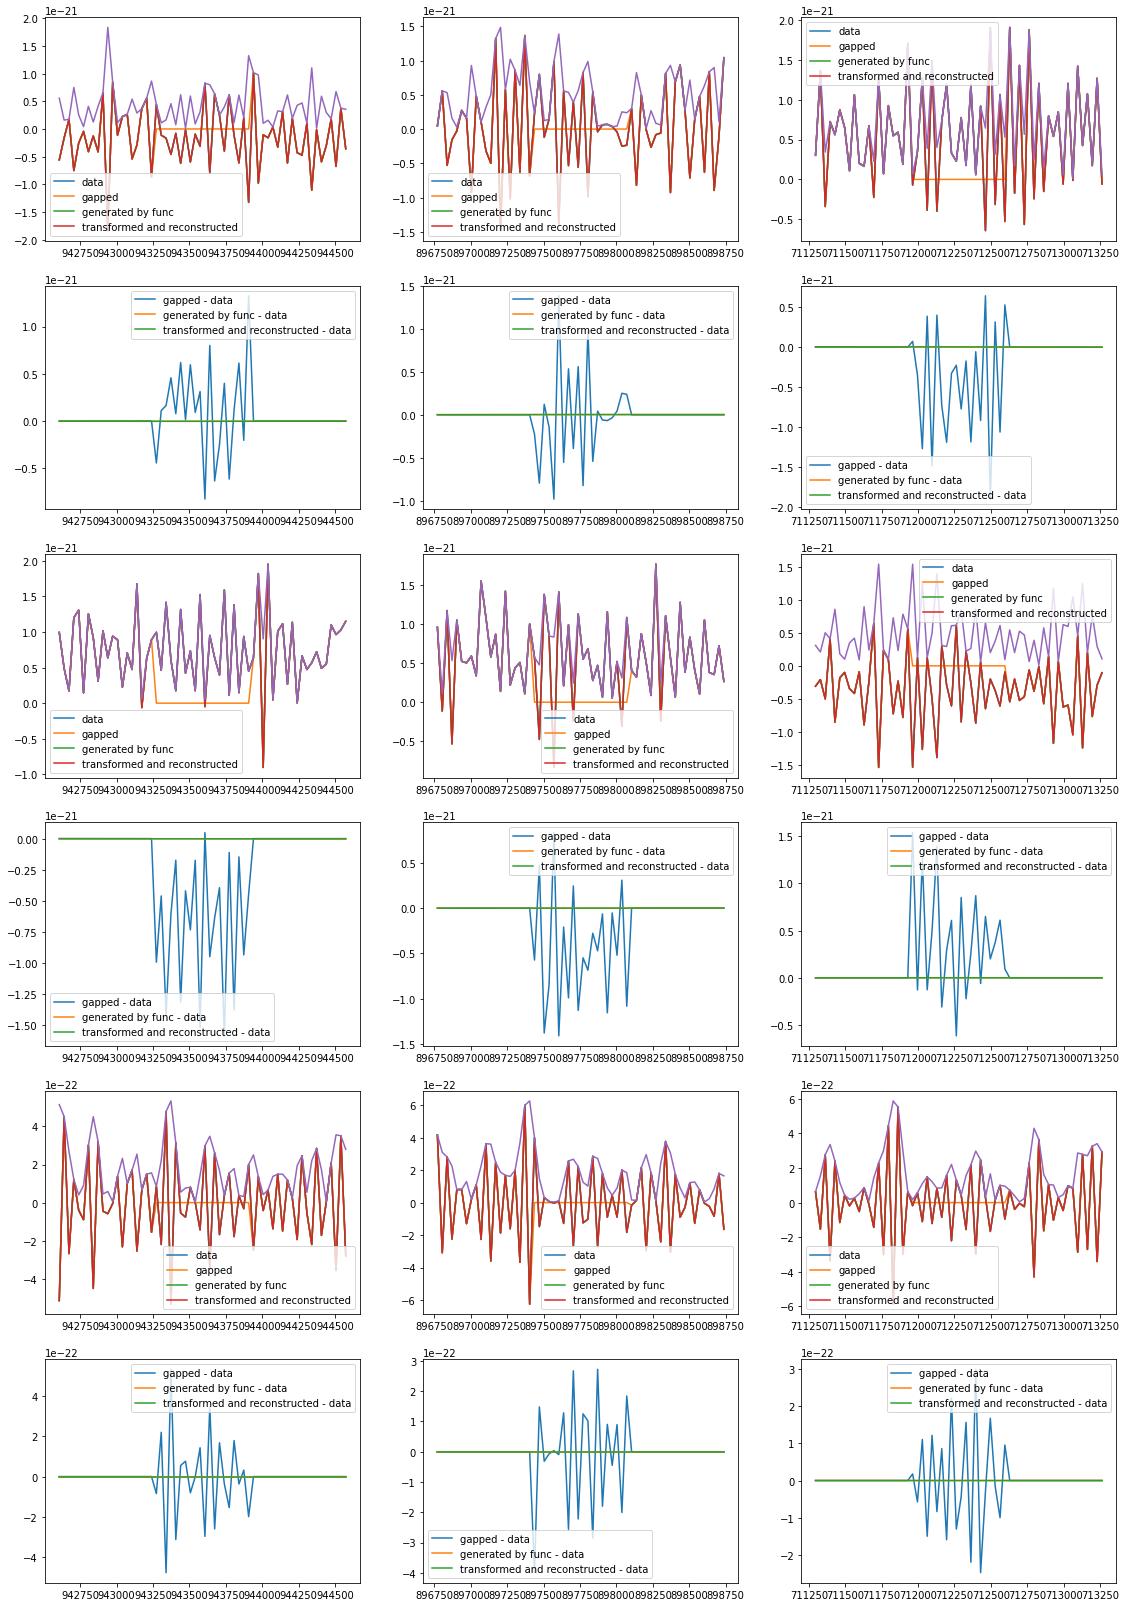

In [7]:
def view_gaps(ts,ys,gapstarts,gapends,labels=None):
    n=len(gapstarts)
    fig, axs = plt.subplots(nchan*2,n,figsize=[6.4*n,4.8*nchan*2],squeeze=False)
    for i in range(n):
        i0=gapstarts[i]-gaplength
        iend=gapends[i]+gaplength
        for j in range(nchan):
            ax=axs[j*2,i]         
            for yi in ys:
                ax.plot(ts[i0:iend],yi[j][i0:iend].real)
            ax.plot(ts[i0:iend],np.abs(ys[0][j][i0:iend]))
            if labels is not None: ax.legend(labels=labels)
            ax=axs[j*2+1,i]
            for yi in ys[1:]:
                ax.plot(ts[i0:iend],yi[j][i0:iend].real-ys[0][j][i0:iend].real)
            if labels is not None: ax.legend(labels=[l+' - '+labels[0] for l in labels[1:]])
    plt.show()

view_gaps(ts,[y,y_masked,yy,yyt,],gapstarts[:3],gapends[:3],labels=['data','gapped','generated by func','transformed and reconstructed'])

### Define a bayesdawn psd model class built on the lisabeta psd model
Then show a test of its application

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MLDC modules could not be loaded.
3.75e-07 < f < 0.014999374999999999  nd= 29999  nf= 29999 df= 5e-07
nn,nf,nf-nn 29999 29999 0
nt,dt: 59996 33.33472228009501
recon scale: 0.029998749999999998 59996 5e-07
fsshape: (29999,)
Nt,fs,scalefac: 59996 0.029998 0.03333555570371358
shape: (59996,) -> (29999,)  ff.shape (29999,)
Nt,fs,scalefac: 59996 0.029998 0.03333555570371358
shape: (59996,) -> (29999,)  ff.shape (29999,)
Nt,fs,scalefac: 59996 0.029998 0.03333555570371358
shape: (59996,) -> (29999,)  ff.shape (29999,)
tutorial_scalefac 0.03333555570371358
MLDC modules could not be loaded.
MLDC modules could not be loaded.
ichan= 0
x.shape,psd.shape: (29999,) (29999,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ichan= 1
x.shape,psd.shape: (29999,) (29999,)
ichan= 2
x.shape,psd.shape: (29999,) (29999,)


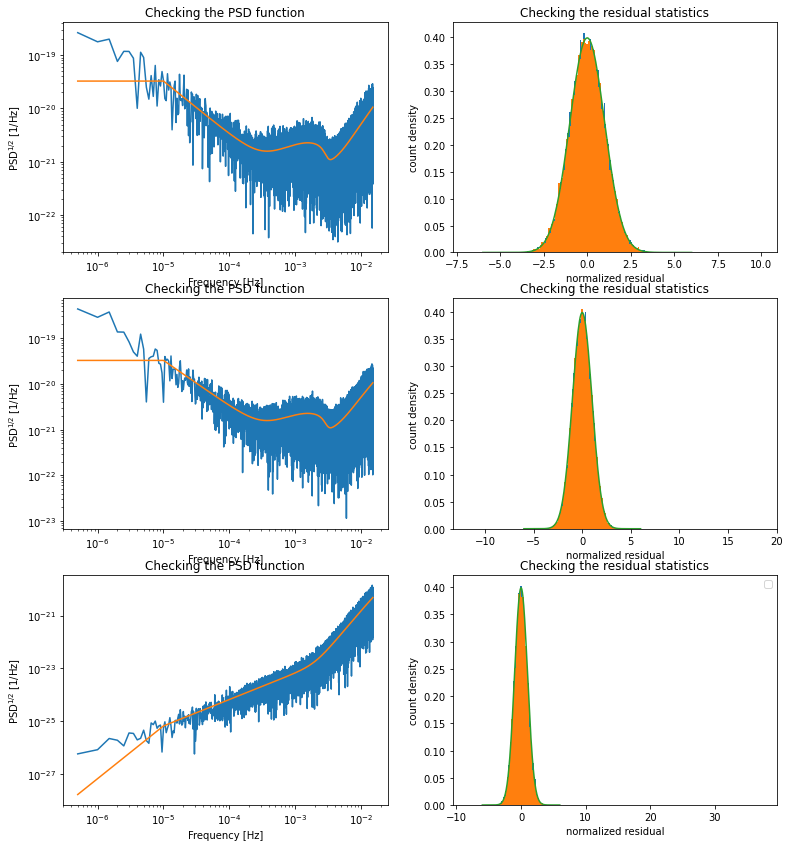

In [8]:
# Embedd the PSD function in a class
from bayesdawn import datamodel, psdmodel
class chanPSD(psdmodel.PSD):

    def __init__(self, n_data, df, chan, LISAnoise, TDIrescaled=False,f0=0,dered_f0=0,dered_pow=2):
        psdmodel.PSD.__init__(self, n_data, df, fmin=None, fmax=None)
        self.LISAnoise=LISAnoise
        self.chan=chan+1
        self.TDIrescaled=TDIrescaled
        self.f0=f0-df
        self.df=df
        self.i0=int(f0/df+0.5)
        self.dered_f0=dered_f0
        self.dered_pow=dered_pow
        
    def psd_fn(self, x):
        #print('Calling pyLISAnoise with:\n  LISAnoise=',self.LISAnoise,"\n  chan=",self.chan,"\n  TDIrescaled=",resc,"\n  x=",x)
        
        xx=x
        psd = pyLISAnoise.LISANoisePSDFunction(self.LISAnoise,self.chan,TDIrescaled=self.TDIrescaled).apply(xx)
        print('x.shape,psd.shape:',x.shape,psd.shape)        
        #psd[:self.i0]=psd[self.i0]
        if self.dered_f0>0:
            cut=self.dered_f0
            psd[xx<cut]*=(xx[xx<cut]/cut)**self.dered_pow #hack the low-f fall-off test
        return psd

# Instantiate the psd class
psd_cls=[]
for i in range(3):
    psd_cls.append(chanPSD(nt,df,i,LISAnoise,f0=fs[0],dered_f0=1e-5))   
 
#Check the PSD on the reconstructed time-domain data
yyn = reconstruct_time_domain(datan,3)
yynfft=[]
ff=[]
print('fsshape:',fs.shape)
for td in yyn:
    yynfft += [np.fft.rfft(td)] 
    Nt = len(td)
    fs2nyq = Nt*df
    tutscalefac=np.sqrt(2 / (Nt*fs2nyq))
    print('Nt,fs,scalefac:',Nt,fs2nyq,tutscalefac)
    ff += [np.fft.rfftfreq(Nt) * fs2nyq]
    print('shape:',td.shape,'->',yynfft[-1].shape,' ff.shape',ff[-1].shape)
#From tutorial: scalefac=np.sqrt(2 / (n_data*fs)), but 'fs'=n_data*df
tutorial_scalefac=np.sqrt(2 / df)/(len(yynfft[0])-1)/2
print('tutorial_scalefac',tutorial_scalefac)
# Load plotting configuration
from bayesdawn.utils import postprocess
#postprocess.plotconfig(lbsize=20, lgsize=16, autolayout=True, figsize=(8, 6),
#                       ticklabelsize=20)
# Plot data against PSD
fig, axs = plt.subplots(nchan,2,figsize=[6.4*2,4.8*nchan])

for ichan in range(nchan):
    print('ichan=',ichan)
    ax=axs[ichan,0]
    ax.set_title(r"Checking the PSD function")
    ax.set_xlabel(r"Frequency [Hz]")
    ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
    n_fft=yynfft[ichan]
    ffs=ff[ichan]
    #psd=psd_cls[ichan].calculate(ffs)
    psd=psd_cls[ichan].psd_fn(ffs)
    #psd[ffs<fs[0]]=1e-72
    ax.loglog(ffs[ffs>0], np.abs(n_fft[ffs>0]) * tutorial_scalefac, label="Noise")
    ax.loglog(ffs[ffs>0], np.sqrt(psd[ffs>0]), label="PSD model")
    #ax.loglog(f[f>0], np.sqrt(psdN), label="PSD model (None)")
    plt.legend()
    #Check the statistics on the residual
    #df=fs/n_data
    nbins=int(np.sqrt(len(n_fft)))
    ax=axs[ichan,1]
    ax.hist(n_fft.real[ffs>0][:-1]*tutorial_scalefac/np.sqrt(psd[ffs>0][:-1]/2),bins=nbins,density=True,label="real part")
    ax.hist(n_fft.imag[ffs>0][:-1]*tutorial_scalefac/np.sqrt(psd[ffs>0][:-1]/2),bins=nbins,density=True,label='imag part')
    x=np.linspace(-6,6,nbins)
    ax.plot(x,norm.pdf(x))
    ax.set_title(r"Checking the residual statistics")
    ax.set_xlabel(r"normalized residual")
    ax.set_ylabel(r"count density") 
plt.show()

### Define some functions for concretely applying the bayesdawn gap impuation on  a set of FD data channels
- create_imputation: Make a (multi-channel) set of bayesdawn imputation models from given PSD data with a specified gap mask
- update_imputation: Perform the imputation on a set of FD residual data returning a revised version of the residual data, again in FD with re-drawn gap data.

In [9]:
# instantiate imputation class
def create_imputation(mask,psd,nchan,method=None):
    imp=[]
    for i in range(nchan):
        s=np.zeros(len(mask))  #for residual 'signal' is zero
        if method is not None and method=='woodbury':
            imp += [datamodel.GaussianStationaryProcess(s, mask, psd[i], method='woodbury')]
        elif method is None:
            imp += [datamodel.GaussianStationaryProcess(s, mask, psd[i], na=60, nb=60)]
        else: raise ValueError("Not recognized: method="+method)
        # perform offline computations
        imp[i].compute_offline()
        # If you want to update the deterministic signal (the mean of the Gaussian process)
        #imp_cls[i].update_mean(s)
        # If you want to update the PSD model
        #imp_cls[i].update_psd(psd_cls)
    return imp

def update_imputation(mask,imp,nchan,resid_data,nfuzz=0,psd=None,verbose=False):
    #Expecting residual data in the format (eg for nchan=3)
    #[[f0,Ar0,Ai0,Er0,Ei0,Tr0,Ti0],[f1,Ar1,Ai1,...],...]
    #print('resid_data=',resid_data)
    resid=resid_data.copy()
    fs=resid[:,0]
    nd=len(resid)
    df=(fs[-1]-fs[0])/(nd-1) 
    #Optionally 'fuzz' the edges of the FD data before transforming
    #Based on the PSD
    #n_fft=sqrtS*n_fft*[np.sqrt(n_data*fs/4)] []-->[nt/2*sqrt(df)]
    if nfuzz>0 and psd is not None:
        nf=nd+int(fs[0]/df-.5)
        print('Applying fuzz of size',nfuzz,'below f=',fs[nfuzz],'and above f=',fs[nf-nfuzz])
        nt=2*nf-1
        scale=nt*np.sqrt(df)/2/(fs[-1]*2)
        lowpsd=np.zeros((nfuzz,2*nchan))
        for i in range(nchan):
            lowpsd[:,2*i]=psd[i].psd_fn(np.arange(nfuzz)*df)
            lowpsd[:,2*i+1]=lowpsd[:,2*i]
        lowfuzz=np.random.normal(size = (nfuzz,2*nchan))
        lowfuzz*=np.sqrt(lowpsd)*scale
        dlowfuzz=resid[:nfuzz,1:]-lowfuzz
        resid[:nfuzz,1:]=lowfuzz
        hipsd=np.zeros((nfuzz,2*nchan))
        for i in range(nchan):
            hipsd[:,2*i]=psd[i].psd_fn(np.arange(nf-nfuzz,nf)*df)
            hipsd[:,2*i+1]=hipsd[:,2*i]        
        hifuzz=np.random.normal(size = (nfuzz,2*nchan))
        hifuzz*=np.sqrt(hipsd)*scale
        dhifuzz=resid[nf-nfuzz:,1:]-hifuzz
        resid[nf-nfuzz:,1:]=hifuzz
    y=reconstruct_time_domain(resid,nchan)
    y_rec=[]
    for i in range(nchan):
        # Impute missing data
        #y_masked=mask*y[i]
        y_masked=y[i]
        #y_rec += [imp[i].draw_missing_data(y_masked)]
        y_rec += [imp[i].impute(y_masked, draw=True)]
    if verbose:
        ich=2
        nt=len(y[ich])
        dt = 1/(fs[-1]*2)
        ts=np.arange(nt)*dt
        print('Time comparison chan '+str(ich)+':')
        tdiffs=np.abs(y[ich]-y_rec[ich])>1e-24
        count = np.count_nonzero(tdiffs)
        print('  ',count,'of',nt,'different.')
        #for i in range(len(y[ich])):
        #    if tdiffs[i]:
        #        print('  ',i,ts[i],y[ich][i],y_rec[ich][i])
    if verbose:view_gaps(ts,[y,y_rec],gapstarts[:3],gapends[:3],labels=['orig','new'])    
        
    result=construct_specialized_data(y_rec,nchan,df,fs[0])
    if verbose and psd is not None:
        control=construct_specialized_data(y,nchan,df,fs[0])
        plot_compare_spectra([resid_data,resid,control,result],PSDset=psd,labels=['orig','fuzzed','control','result'])
    return result


### Apply the imputation tothe noise data and compare spectra

3.75e-07 < f < 0.014999374999999999  nd= 29999  nf= 29999 df= 5e-07
nn,nf,nf-nn 29999 29999 0
nt,dt: 59996 33.33472228009501
recon scale: 0.029998749999999998 59996 5e-07
con scale: 0.02999875 59996 5e-07
x.shape,psd.shape: (59997,) (59997,)
x.shape,psd.shape: (59997,) (59997,)
Computation of autocovariance + PSD took 0.03470492362976074
Start Toeplitz system precomputations...
shape of c_mat is (59996, 60)
x.shape,psd.shape: (59997,) (59997,)
x.shape,psd.shape: (59997,) (59997,)
Computation of autocovariance + PSD took 0.07980084419250488
Start Toeplitz system precomputations...
shape of c_mat is (59996, 60)
x.shape,psd.shape: (59997,) (59997,)
x.shape,psd.shape: (59997,) (59997,)
Computation of autocovariance + PSD took 0.06346988677978516
Start Toeplitz system precomputations...
shape of c_mat is (59996, 60)
created
Applying fuzz of size 15000 below f= 0.007500375 and above f= 0.007499875
x.shape,psd.shape: (15000,) (15000,)
x.shape,psd.shape: (15000,) (15000,)
x.shape,psd.shape: (1

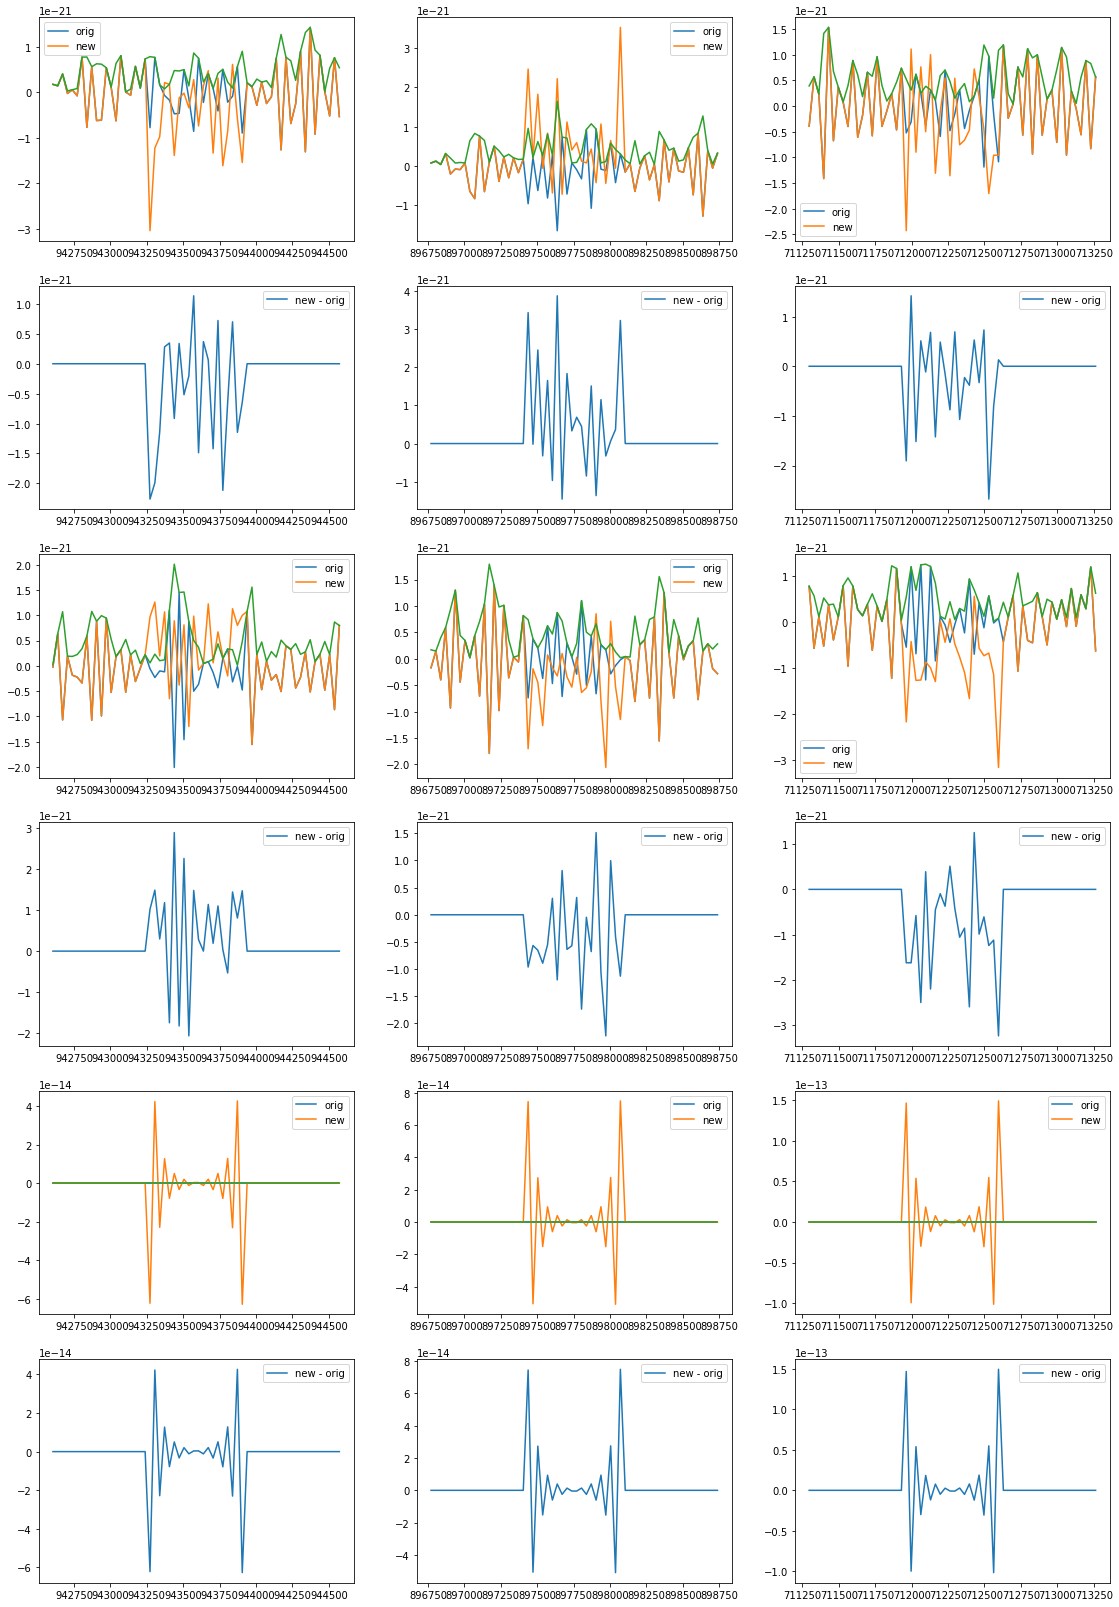

con scale: 0.02999875 59996 5e-07
con scale: 0.02999875 59996 5e-07
plot_compare_spectra: Assuming list of np data.
x.shape,psd.shape: (29999,) (29999,)
x.shape,psd.shape: (29999,) (29999,)
x.shape,psd.shape: (29999,) (29999,)
chan 0 data set stds: [8.26521060e-18 7.23357785e-18 7.23357785e-18 7.24205431e-18]
i max: 2 69.4183056615829
i max: 16836 4.094992807800292
i max: 16836 4.094992807800292
i max: 16836 4.159384710353466
chan 1 data set stds: [9.17786778e-18 7.22323024e-18 7.22323024e-18 7.22779422e-18]
i max: 0 65.79772832843032
i max: 10749 4.234350433882484
i max: 10749 4.234350433882484
i max: 10749 3.9992758313713743
chan 2 data set stds: [2.66138064e-18 2.67852839e-18 2.67852839e-18 1.52312541e-11]
i max: 2 40260003184995.4
updated
plot_compare_spectra: Assuming list of np data.
chan 0 data set stds: [8.26521060e-18 7.24205431e-18 8.26521060e-18]
i max: 26025 4.427199372970116
i max: 16836 4.159384710353466
i max: 26025 4.427199372970115
chan 1 data set stds: [9.17786778e-18

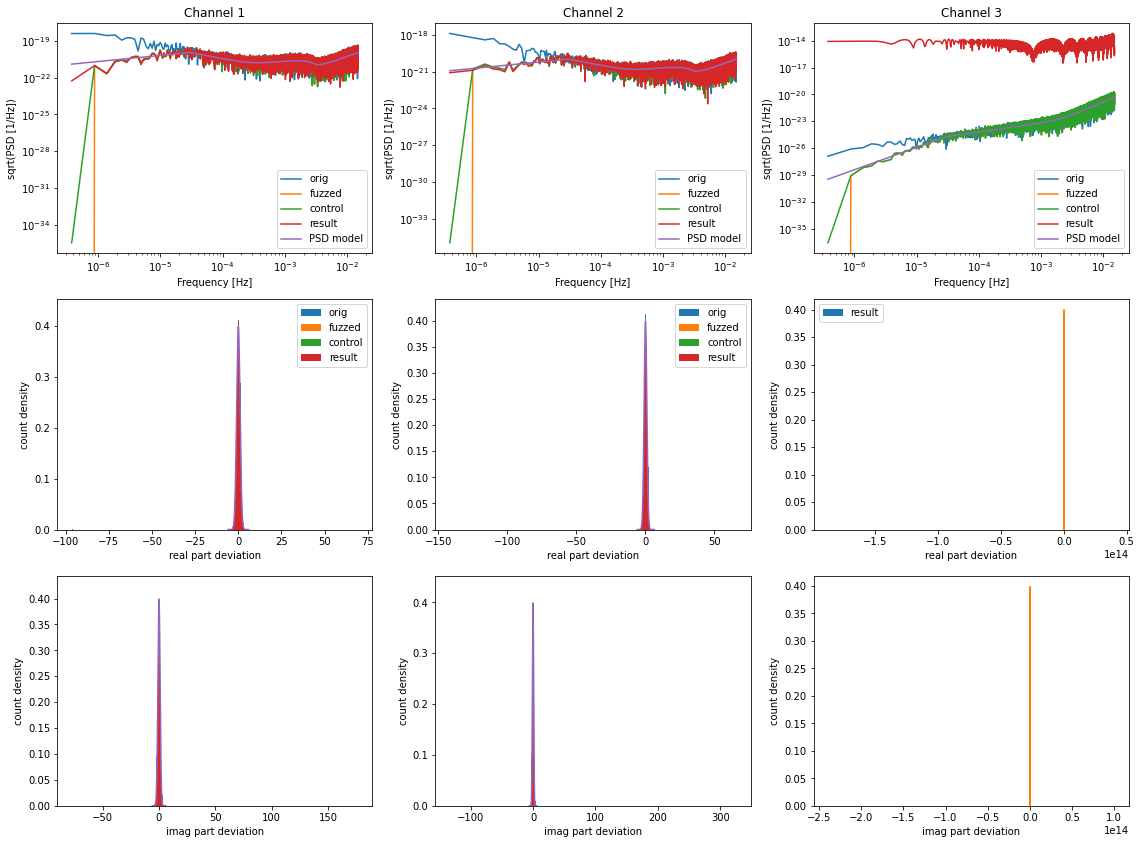

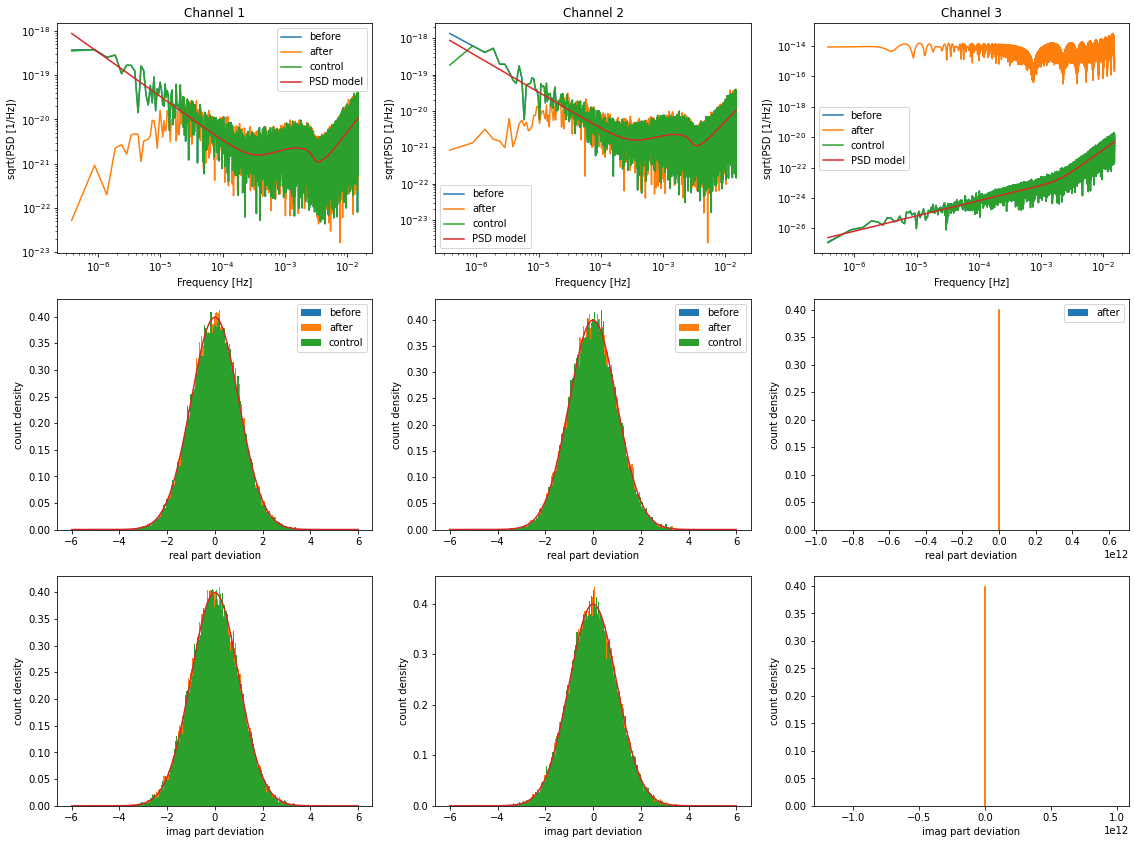

In [10]:
fs=datan[:,0]
df=(fs[-1]-fs[0])/(len(datan)-1) 
datan_control=construct_specialized_data(reconstruct_time_domain(datan,nchan),nchan,df,fs[0])
psd_cls=[]
for i in range(3):
    psd_cls.append(chanPSD(nt,df,i,LISAnoise,f0=fs[0],dered_f0=3e-5,dered_pow=3))   
imp=create_imputation(mask,psd_cls,nchan,method='woodbury')
print('created')
datan1=update_imputation(mask,imp,nchan,datan,verbose=True,psd=psd_cls,nfuzz=15000)
print('updated')
plot_compare_spectra([datan,datan1,datan_control],LISAnoise,labels=['before','after','control'])
                                            

### Do it again (non-Woodbury)


x.shape,psd.shape: (59997,) (59997,)
x.shape,psd.shape: (141,) (141,)
Computation of autocovariance + PSD took 0.03506779670715332
x.shape,psd.shape: (59997,) (59997,)
x.shape,psd.shape: (141,) (141,)
Computation of autocovariance + PSD took 0.029721498489379883
x.shape,psd.shape: (59997,) (59997,)
x.shape,psd.shape: (141,) (141,)
Computation of autocovariance + PSD took 0.024555206298828125
Applying fuzz of size 15000 below f= 0.007500375 and above f= 0.007499875
x.shape,psd.shape: (15000,) (15000,)
x.shape,psd.shape: (15000,) (15000,)
x.shape,psd.shape: (15000,) (15000,)
x.shape,psd.shape: (15000,) (15000,)
x.shape,psd.shape: (15000,) (15000,)
x.shape,psd.shape: (15000,) (15000,)
3.75e-07 < f < 0.014999374999999999  nd= 29999  nf= 29999 df= 5e-07
nn,nf,nf-nn 29999 29999 0
nt,dt: 59996 33.33472228009501
recon scale: 0.029998749999999998 59996 5e-07
Time comparison chan 2:
   60 of 59996 different.


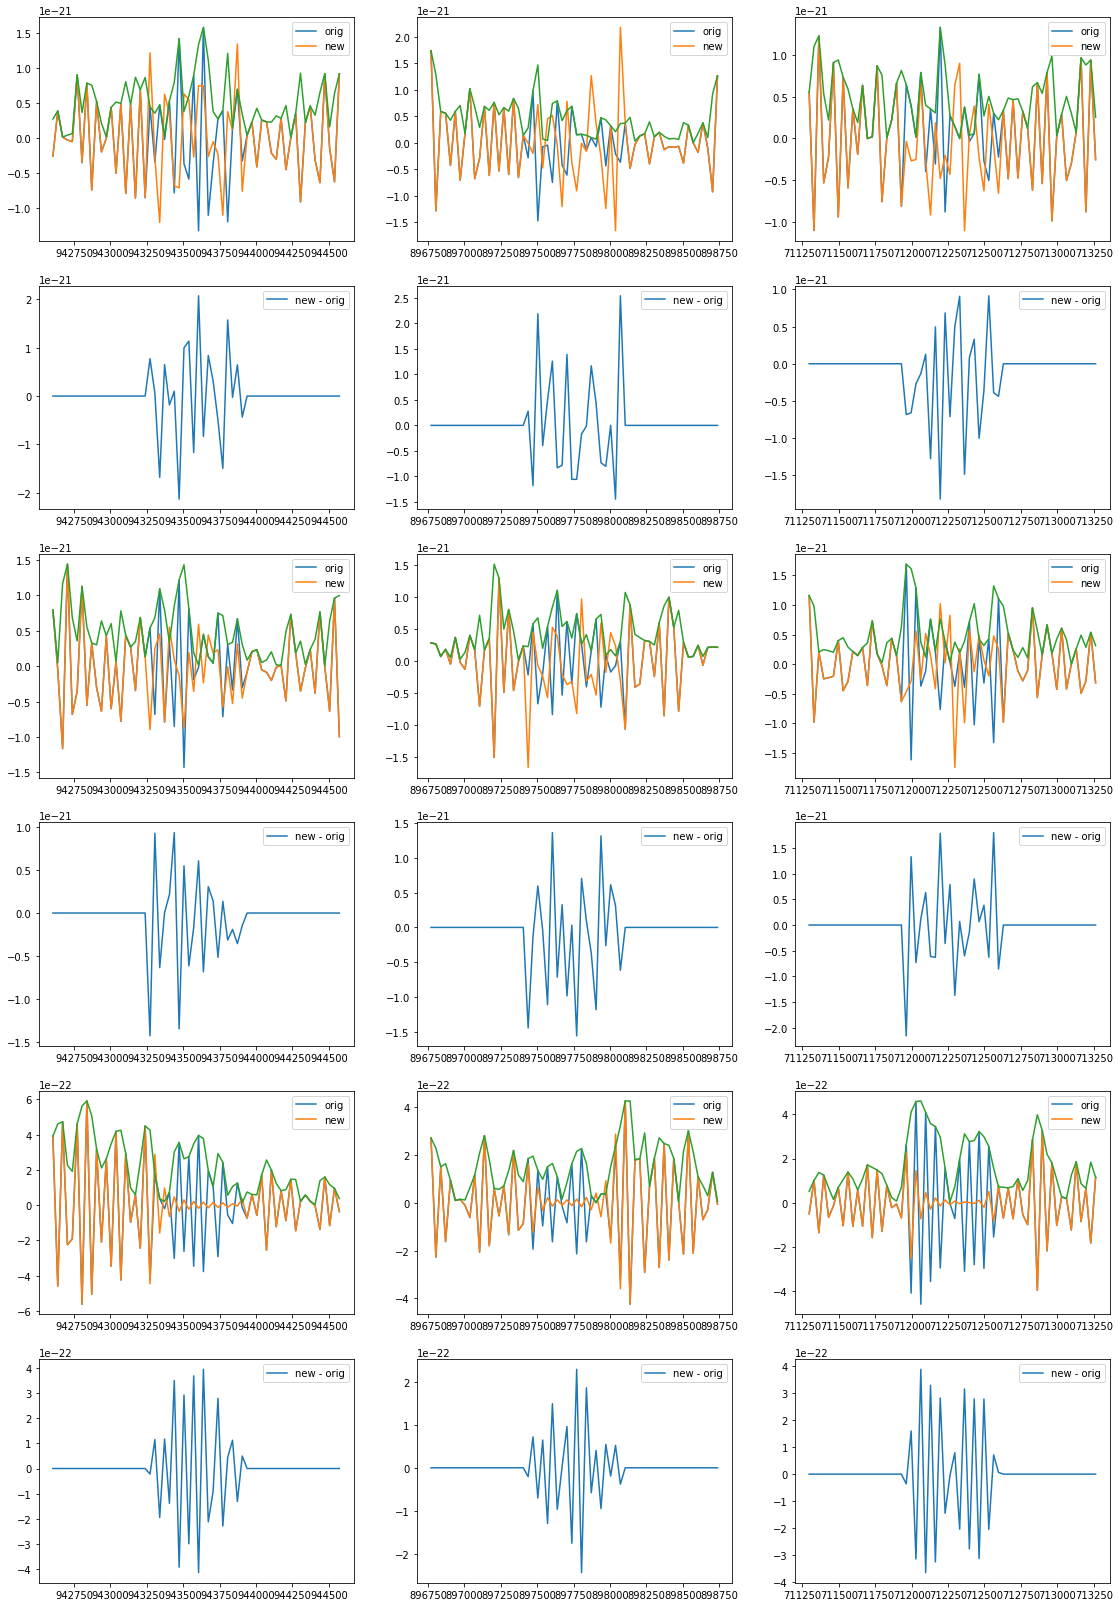

con scale: 0.02999875 59996 5e-07
con scale: 0.02999875 59996 5e-07
plot_compare_spectra: Assuming list of np data.
x.shape,psd.shape: (29999,) (29999,)
x.shape,psd.shape: (29999,) (29999,)
x.shape,psd.shape: (29999,) (29999,)
chan 0 data set stds: [8.26521060e-18 7.22583311e-18 7.22583311e-18 7.22688889e-18]
i max: 2 69.4183056615829
i max: 28505 4.2080061083727065
i max: 28505 4.2080061083727065
i max: 28505 4.1405008142253426
chan 1 data set stds: [9.17786778e-18 7.28754127e-18 7.28754127e-18 7.28597276e-18]
i max: 0 65.79772832843032
i max: 13446 3.804106333884587
i max: 13446 3.8041063338845857
i max: 13446 3.731216786237578
chan 2 data set stds: [2.66138064e-18 2.64816552e-18 2.64816552e-18 2.64703476e-18]
i max: 0 214.44498303272428
i max: 5690 3.7329459596182923
i max: 5690 3.732945959618299
i max: 0 197.28071463930948


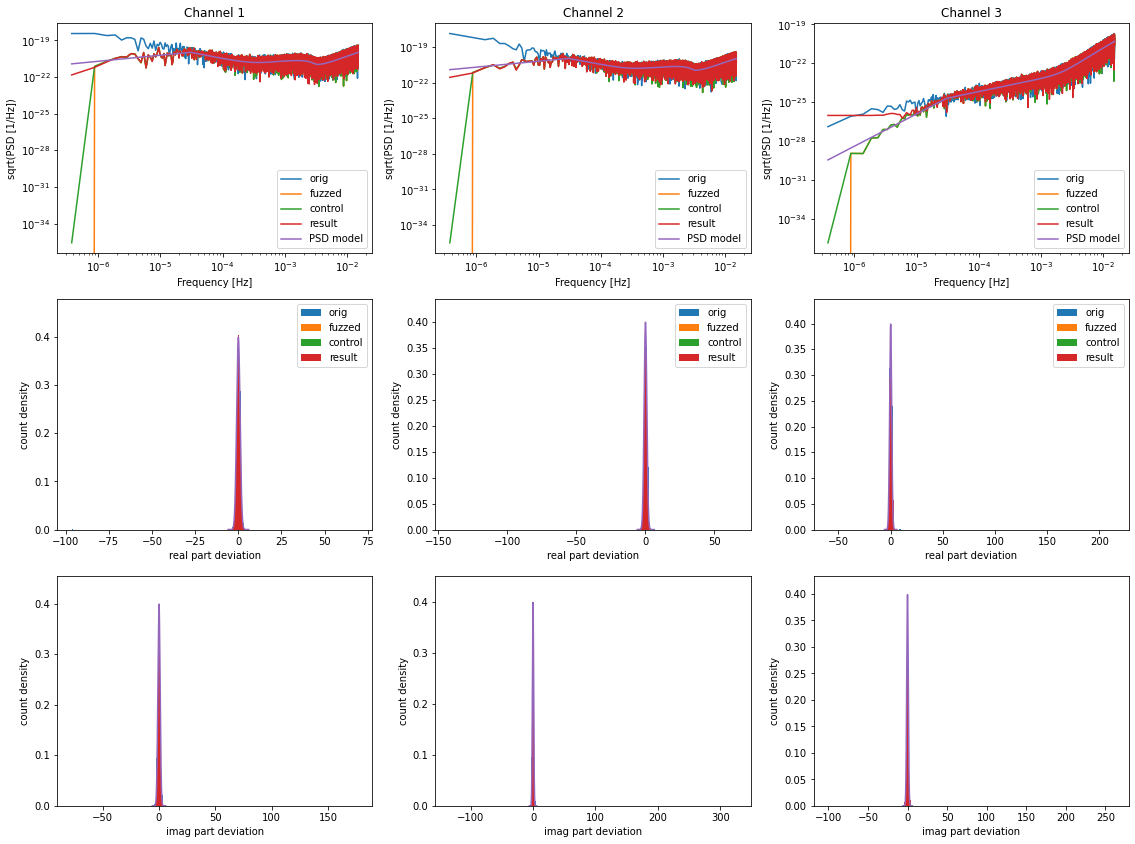

In [11]:
imp=create_imputation(mask,psd_cls,nchan)
datan2=update_imputation(mask,imp,nchan,datan,nfuzz=15000,psd=psd_cls,verbose=True)
#plot_compare_spectra([datan,datan2,datan_control],LISAnoise,labels=['before','after','control'])




In [12]:
help(chanPSD)

Help on class chanPSD in module __main__:

class chanPSD(bayesdawn.psdmodel.PSD)
 |  chanPSD(n_data, df, chan, LISAnoise, TDIrescaled=False, f0=0, dered_f0=0, dered_pow=2)
 |  
 |  Method resolution order:
 |      chanPSD
 |      bayesdawn.psdmodel.PSD
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, n_data, df, chan, LISAnoise, TDIrescaled=False, f0=0, dered_f0=0, dered_pow=2)
 |      Instantiate the PSD estimator class.
 |      
 |      Parameters
 |      ----------
 |      n_data : int
 |          size of analyzed data
 |      fs : float
 |          sampling frequency of analyzed data
 |      fmin : float
 |          minimum frequency where to estimate the PSD
 |      fmax : float
 |          maximum frequency where to estimate the PSD
 |  
 |  psd_fn(self, x)
 |      Returns the value of the PSD estimate at frequency x
 |      
 |      Parameters
 |      ----------
 |      x : array_like
 |          frequency
 |      
 |      Returns
 |      -------
 |

[ 0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01
  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01
  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01
  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01
  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01
  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01
  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01
  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01  0.01 -0.01
  0.01 -0.01  0.01 -0.01]


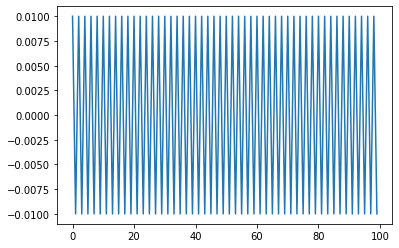

In [13]:
n=100
x=np.arange(n)
y=x.copy()
yfft=np.fft.rfft(y)
yfft=yfft*0;yfft[-1]=1
xx=np.fft.irfft(yfft)
k=np.fft.rfftfreq(n)
plt.plot(x,xx)
print(xx)